In [1]:
from datetime import date

import pandas as pd
import numpy as np

from matplotlib.pylab import plt
from matplotlib import colors

from IPython.display import Image



import seaborn as sns

import requests
import json

sns.set_style("white")

sns.set_context("paper")
dpi = 200
figsize=(15, 6)


%matplotlib inline

# A Colour-Coded Segmented Bar Chart
I've been doing a lot of COVID-19 analysis recently. Over the weekend I wanted to produce a particular type of graph for a blog post that I was working on about COVID-19 lockdowns and mobility levels. I wanted a bar graph with the following:
* Each bar to reflect the total mobility drop experienced by a country over the duration of their COVID-19 lockdown; I was using Google's and Apple's mobility datasets for this.
* Each bar to be segmented so that each segment reflected the mobility drop in each consecutive week of their lockdown; in other words, is a lockdown was 10 weeks long then the bar would be made up of 10 segments.
* Each bar to be colour-coded to reflect the deaths per capita for the country in question.

In the spirit of "here's one I made earlier" … below is the graph I ended up producing, and in what follows I will explain how I produced it.

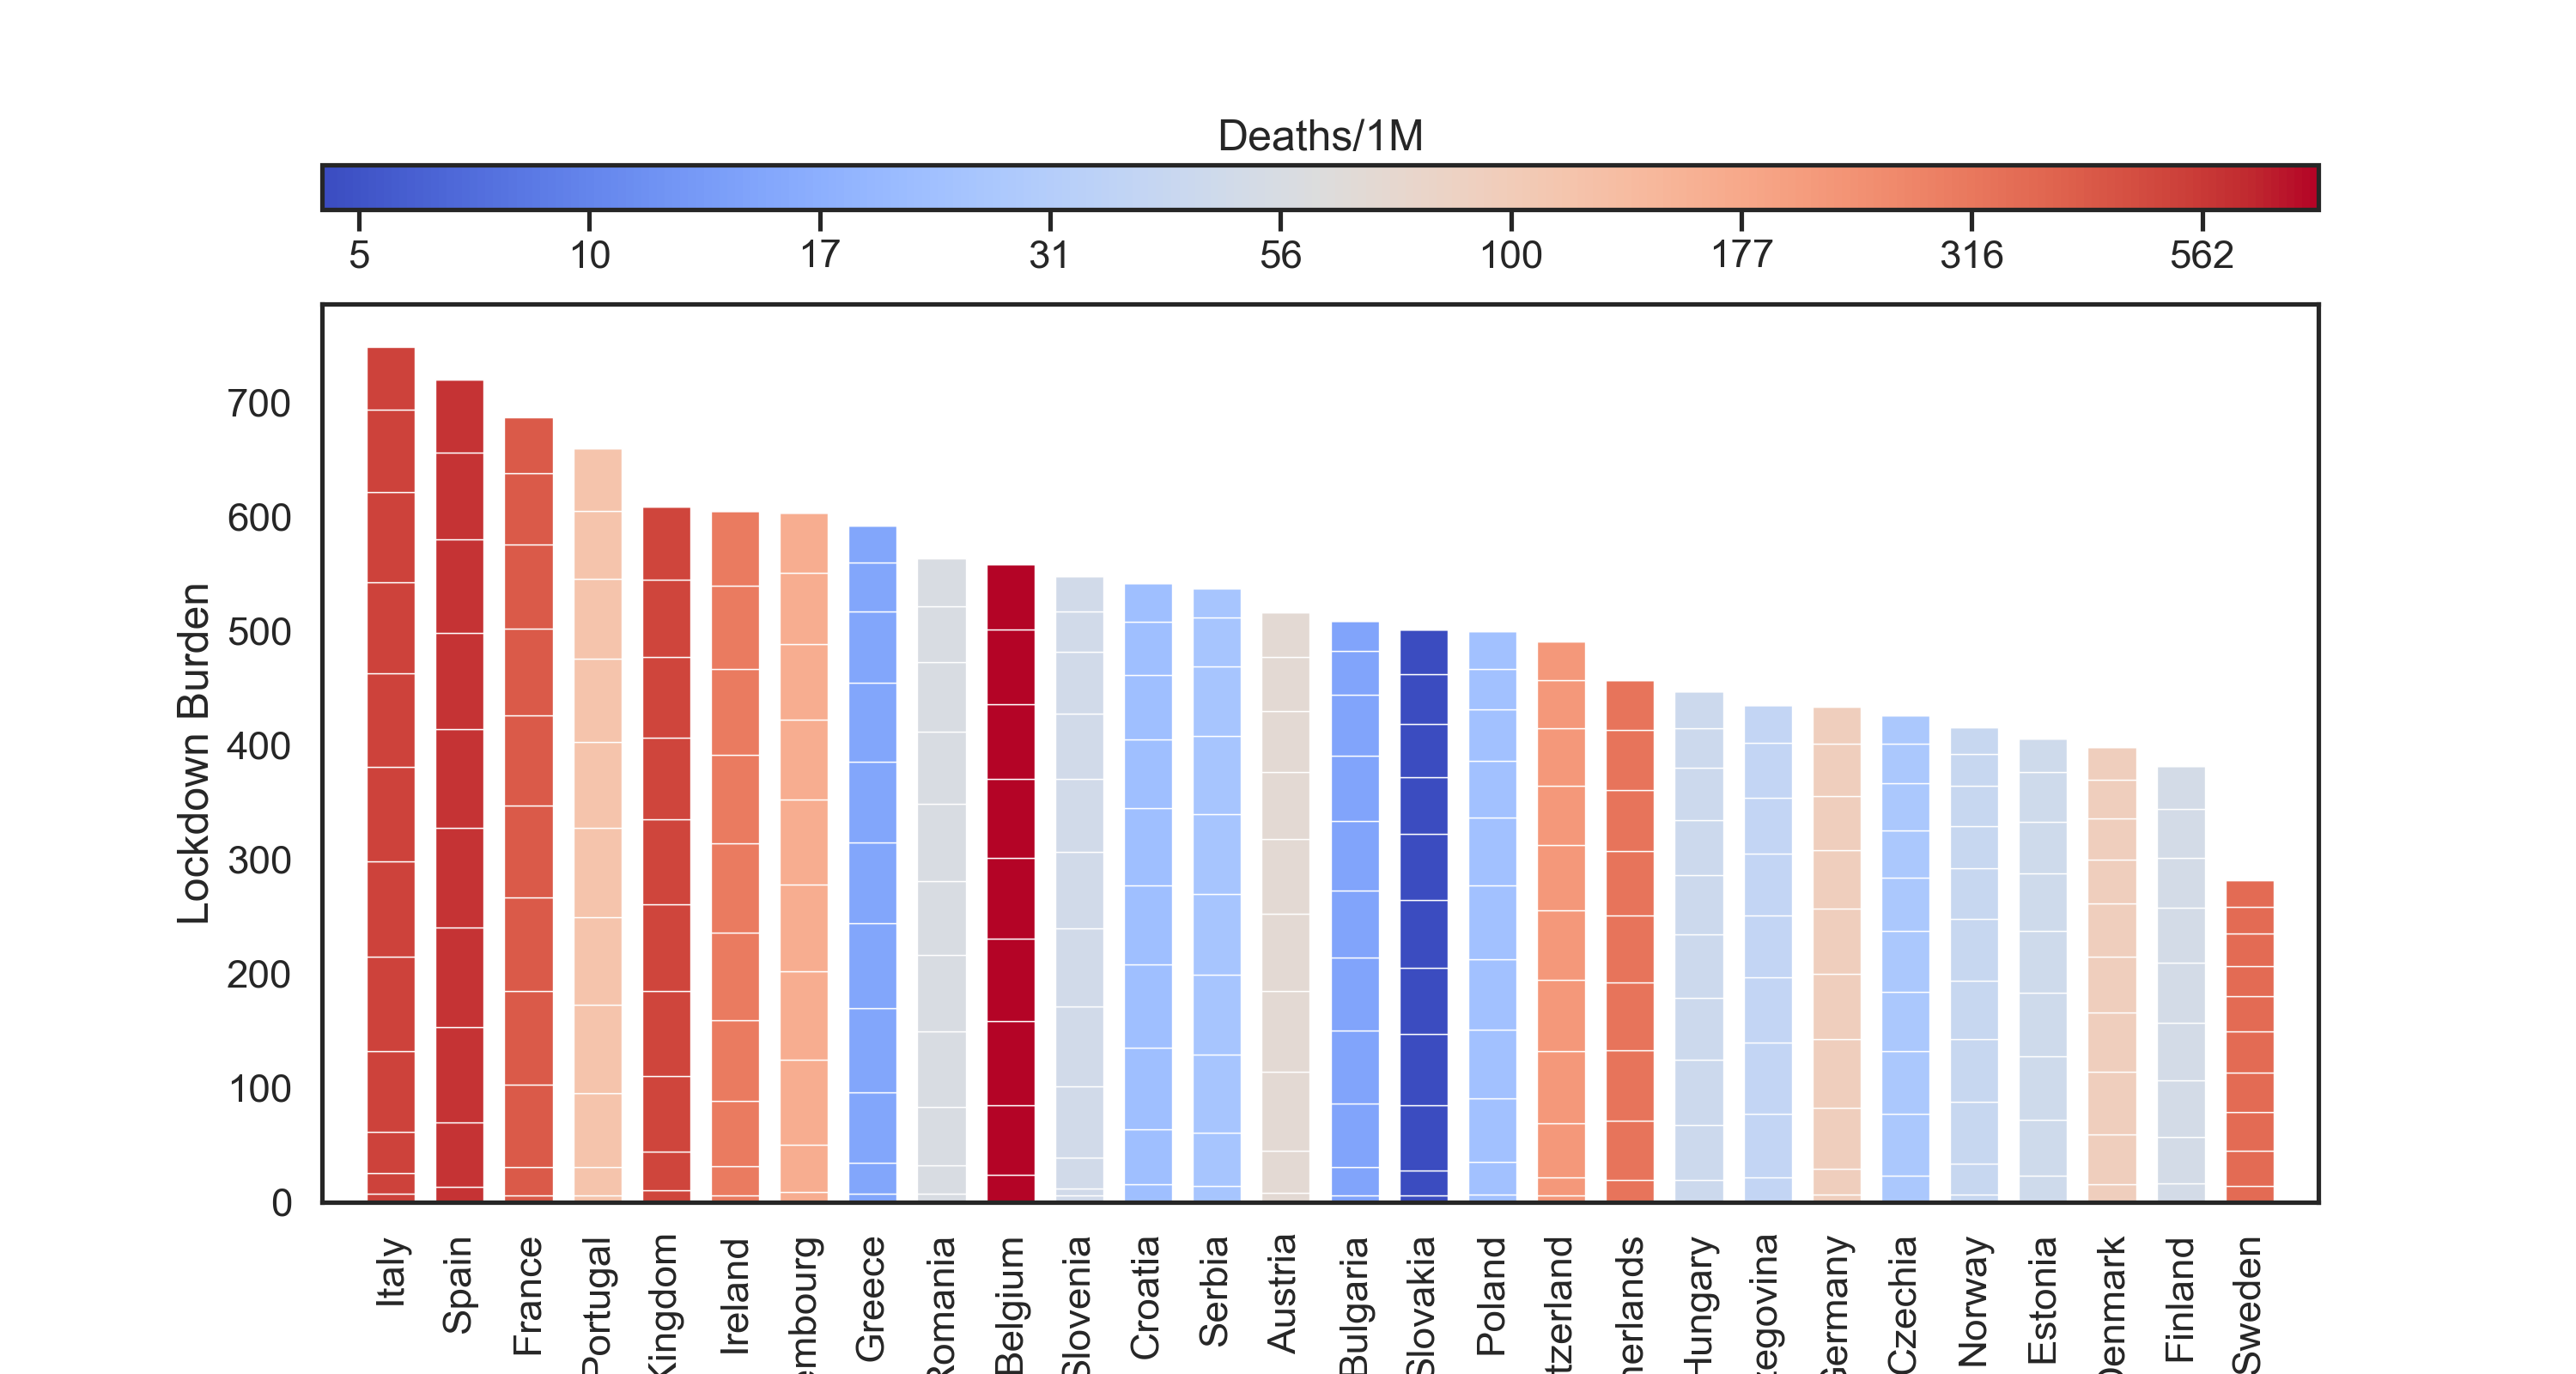

In [2]:
Image("../images/segmented_bar_graph.png", width=800)

At first I assumed this would work out to be a variation on a stacked bar chart but after a bit of searching I came to the conclusion that this was not the right approach. Although a stacked bar chart can deliver the segmented effect, it is not possible to individually colour the bars; instead a stacked bar chart colours the segments so that each bar is made up of a set of ordered, multi-coloured segments. Then I thought that a heatmap might do the trick, but that doesn't work either, because heatmaps use fixed sized cells so we cant produce segments of different sizes.

So instead I came up with a more custom solution by building each bar one segment at a time. The advantage of this is that each bar and segment is individually addressable, and so it is straightforward to control size and colour. In what follows I will incrementally describe the approach taken and the code and sample data can be downloaded from here.

## Sample data

To explain this we need some sample data. Below is the COVID-19 lockdown data that originally motivated the development of this graph. Each row corresponds to a country. There is a column for the log (base 10) of the number of deaths per million for that country (as of mid-May 2020) and then a set of columns with the average percentage mobility drop for each week of a country's lockdown; these weeks are based on the number of week prior to the country's 100th confirmed case.

For example, Austria's death toll is approximately 1,84 deaths per million and it's lockdown began during the week when Austria recorded its 100th case. That week (week 0) there was a 8% drop in mobility (relative to pre-lockdown levels) and over the next few weeks Austria's mobility levels fell by up to 70%.The segment heights in our bars will correspond to these weekly mobility drops.

Incidentally, we use the log of the death rate here only to emphasise differences between death rates given that that the raw deaths per million values are wide ranging in the countries being analysed (from <5 to >500) and th elog scale helps to 'spread' these out a bit.

In [3]:
df = pd.read_csv('../data/segmented_bar_graph_example_data.csv').set_index('country').fillna(0)
df.head()

,log_deaths,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
country,,,,,,,,,,,,,,,
Austria,1.844600,0.000000,0.000000,8.235322,36.764971,69.240609,70.890130,67.479268,64.958915,58.422410,53.599753,47.547835,38.687741,0.0,0.0
Belgium,2.876030,0.000000,0.000000,0.000000,23.783895,61.425109,73.137514,72.631807,70.428046,68.985395,65.570381,64.691677,57.261499,0.0,0.0
Bosnia_and_Herzegovina,1.594080,0.000000,21.579365,56.047619,62.000000,56.904762,54.455782,54.088435,48.653061,48.020408,32.809524,0.000000,0.000000,0.0,0.0
Bulgaria,1.178666,6.374071,24.740646,55.040751,64.342249,63.764265,58.494731,60.585141,57.224373,53.286671,38.377283,26.071429,0.000000,0.0,0.0
Croatia,1.363859,0.000000,15.606125,48.428781,71.536722,72.473454,69.412617,67.156906,60.601690,56.363933,45.961587,33.793651,0.000000,0.0,0.0


To keep things simple lets separate out the weekly mobility data and the deaths. We need to sort the weekly data based on the sum of the weekly values for each country (total height of the bars). A one-liner to do this involves using Pandas assign to create a temporary column based on the sum of the weekly data so that we can sort by this column and then ditch it afterwards using drop.

In [4]:
# Separate the weekly mobility drops and sort them in descending order of the sum of the
# the weekly drops
weeklies = df.drop(columns=['log_deaths'])\
    .assign(s=df.sum(axis=1))\
    .sort_values('s', ascending=False)\
    .drop('s', axis=1)

weeklies.head()

,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
country,,,,,,,,,,,,,,
Italy,0.0,0.000000,7.838259,17.559235,36.115503,71.044683,81.921737,83.611863,82.577606,82.233103,79.772614,78.187686,72.353386,54.991350
Spain,0.0,0.000000,0.000000,13.514706,56.319504,83.610978,86.633163,87.414035,86.463850,83.988378,81.791387,76.064994,63.595238,0.000000
France,0.0,0.000000,0.000000,5.823090,24.977370,71.923062,82.365984,81.526320,80.514407,78.459459,75.887086,73.553137,62.590882,49.285714
Portugal,0.0,5.841252,24.730155,65.193727,76.842267,77.067487,78.179867,75.063611,72.362051,70.279343,59.337758,54.309524,0.000000,0.000000
United_Kingdom,0.0,0.000000,0.000000,10.500087,34.033735,65.632583,74.858312,75.304424,74.332446,71.599056,70.717291,67.628471,63.857143,0.000000


In [5]:
# Use the sorted index from weeklies to sort deaths in the same way.
deaths = df.loc[weeklies.index]['log_deaths']
deaths.head()

country
Italy             2.717928
Spain             2.769666
France            2.624993
Portugal          2.071556
United_Kingdom    2.706952
Name: log_deaths, dtype: float64

## The Segmented Bar
To build our segmented bar, `plot_segments` plots plots each bar's segments separately at the appropriate x-axis coordinate, by creating an individual bar segment for each weekly vaklue and stacking these segments to produce the final bar. Then the full bar plot can be created by applying `plot_segments` to each row of the weekly dataset; we use Pandas apply function to do this.

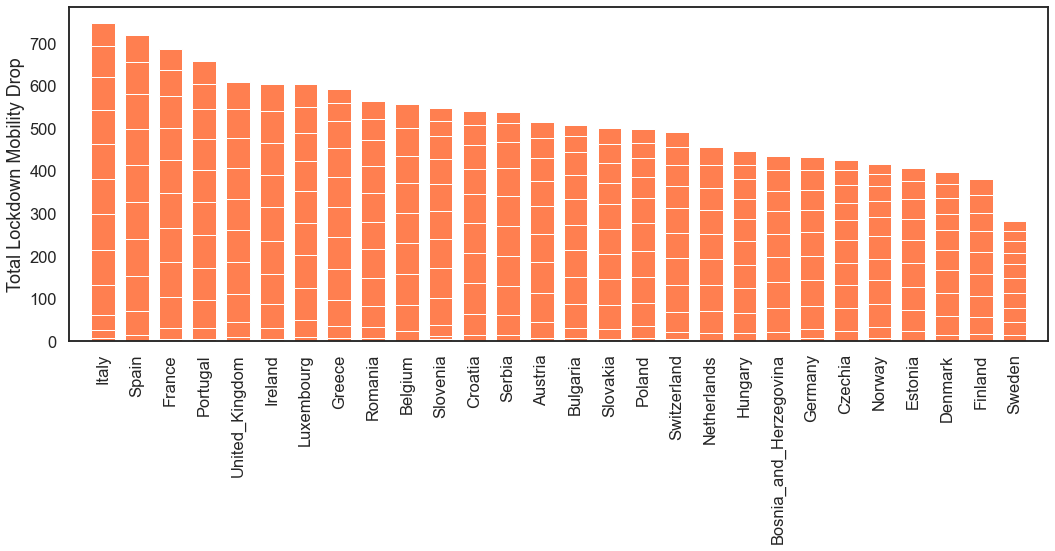

In [6]:
sns.set_context('talk')
                
fig, ax = plt.subplots(figsize=(15,8))

# Plot the segments as a stacked bar for a given x coordinate.
# Each x coordinate value will correspond to a country in our dataset.
def plot_segments(ax, x, segments, width=0.7, min_y=0):
    
    current_y = min_y  # The base of each bar.
    
    # Create a new segment for each weekly value and stack the segments.
    for segment in segments:
        
        # Plot a single bar at x with height=segment and its base at current_y
        ax.bar([x], [segment], width, bottom=current_y, color='coral', linewidth=1)
        
        # Update current_y so that the next segment is plotted on top.
        current_y += segment
        

# Plot each of the country's segments using apply.
weeklies.apply(lambda segments: plot_segments(ax, segments.name, segments), axis=1)

# Rotate the x-axis labels for a better fit.
[label.set_rotation(90) for label in ax.get_xticklabels()]

ax.set_xlim(-1, len(weeklies))
ax.set_ylabel('Total Lockdown Mobility Drop')

fig.tight_layout()

This is the basic segemented bar chart. As per our needs, each country is represented by a segmented bar and the segments correspond to the weekly mobility drops. Differently sized segments indicate differences across the weeks between, and within, countries, and the total height of the bar is the sum of the weekly mobility drops.

We can adjust the size of the segments by changing the width of the bars and/or by adjusting the linewidth (to control the spacing between the segments); by changing edgecolor we can also change the colour of the segmenting. In fact, we can probably even use different shapes for our segments by using custom Matplotlib patches, but that's for another day.

### Colouring the Bars
Now that we have our basic segmented bar chart, which provides us with control over individual segments, it's time to colour the segments of each bar based on some property of the corresponding country; in this case we  use the (log) death rate for each country as this property. 

The best way to do this is to use a colour map (a continuum of colours) scaled to our death rates. We use Matplotlib's `coolwarm` colour map which provides a transition from red through to blue, which we scale it so that the highest death rates map to red and the lowest map to blue.

Then we create a simple dictionary that relates a country name to its corresponding colour. The resulting palette of colours, arranged in order of the countries in our dataframes is shown below for reference

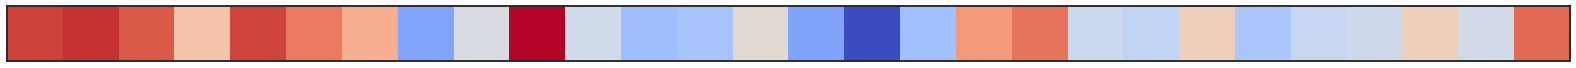

In [7]:
# Use the coolwarm colour map, which comes with Matplotlib.
cmap = plt.cm.coolwarm

# Normalise the log-deaths into a 0, 1 scale
norm = colors.Normalize(vmin=deaths.min(), vmax=deaths.max())

# Now the ith colour in colours corresponds to the ith country in deaths.
colours = cmap(norm(deaths))

# Build a simple colour dictionary indexed by country name.
colour_dict = dict(zip(deaths.index, colours))

# Display the colours. These are in order of the countries in our deaths/weeklies series/dataframe.
sns.palplot(colours)

Now that we have our colours, all we need to do is to change one line of the `plot_segments` function so that instead of using a fixed colour we use for the current country from the colour dictionary. We should also pass colour dictionary into the function and remember too that x is the country name.

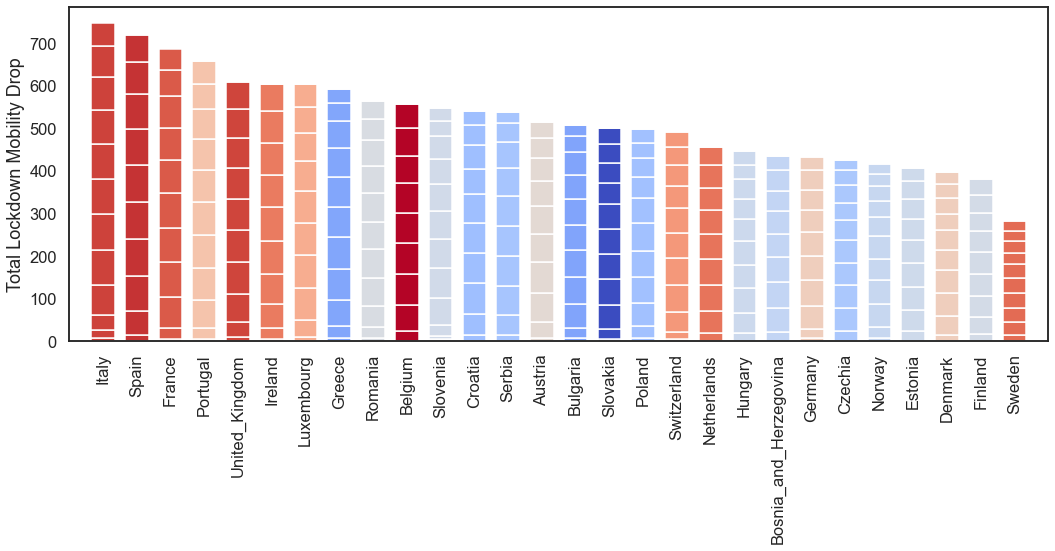

In [8]:
sns.set_context('talk')
                
fig, ax = plt.subplots(figsize=(15,8))

# Plot the segments as a stacked bar at the x coordinate.
def plot_segments(ax, x, segments, width=0.7, min_y=0, colour_dict=colour_dict):
    current_y = min_y
    for segment in segments:
        
        # Plot a single bar at x with height=segment and its base at current_y
        # Colour the bar based on the colour code for x (country)
        ax.bar([x], [segment], width, bottom=current_y, color=colour_dict[x])
        
        # Update current_y so that the next segment is plotted on top.
        current_y += segment
        
# Plot each of the country's segments using apply.
weeklies.apply(lambda segments: plot_segments(ax, segments.name, segments), axis=1)

# Rotate the x-axis labels for a better fit.
[label.set_rotation(90) for label in ax.get_xticklabels()]

ax.set_xlim(-1, len(weeklies))
ax.set_ylabel('Total Lockdown Mobility Drop')

fig.tight_layout()

And there we have it: our segmented bar chart coloured according to the death rate for each country. The final thing we need is a labeled key with which to interpret the colours so that at a glance we can estimate the death rate a colour refers to.

### Adding the Colour Key
To do this we use a Matplotlib colourbar which will display the continuum of colours in our scaled colour map. We present this as a horizontal colourbar above the main bar chart but, in a similar way, we could display a vertical colour bar alongside one of the sides.

For ease of positioning we give the colour bar its own axis and arrange the colour bar and bar chart axes using a gridspec as shown below. Then, after plotting the segmnetde bar chart, we add the colour bar, set its title, and add it's tick labels. And since we use the log (base 10) of death rates, we transform these back to regular death rates before displaying them on the colour bar; in the final version we might want to chose round numbers for these death rates (e.g. 5, 10, 25, 100, 250, 500) but here we go with evenly spaced ticks instead.

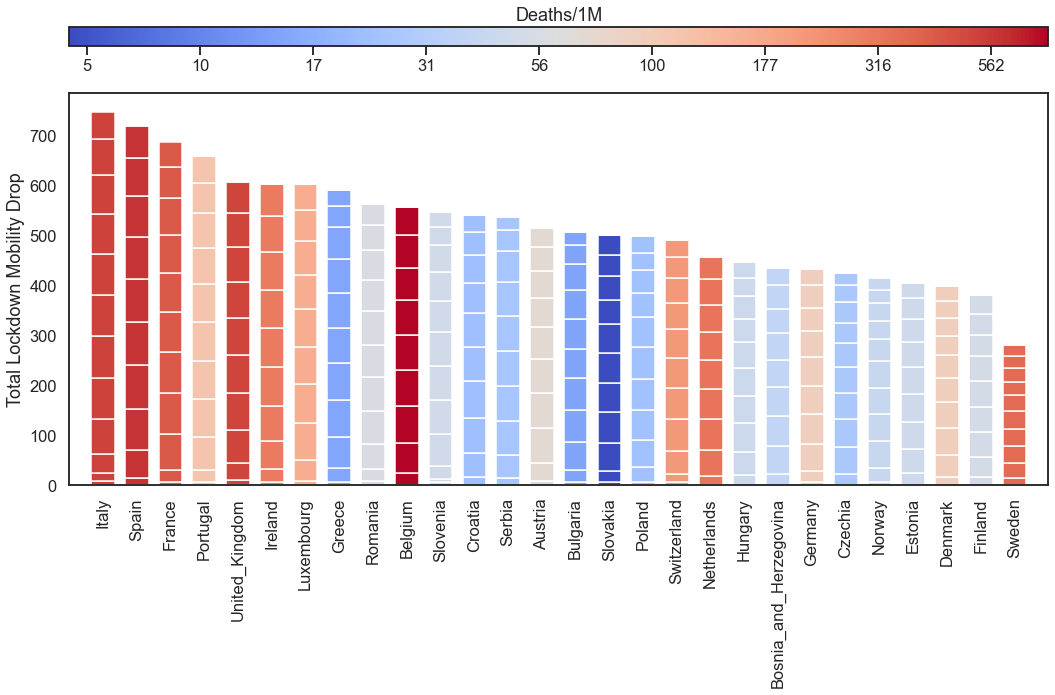

In [9]:
sns.set_context('talk')
                
# Create 2-row gridspec to hold the colour bar (cax) and the main graph (ax)
fig, (cax, ax) = plt.subplots(nrows=2,figsize=(15,10), gridspec_kw={"height_ratios":[.05, 1]})

# --- Creating the  colour map
# Use the coolwarm colour map, which comes with Matplotlib.
cmap = plt.cm.coolwarm

# Normalise the log-deaths into a 0, 1 scale
norm = colors.Normalize(vmin=deaths.min(), vmax=deaths.max())

# Now the ith colour in colours corresponds to the ith country in deaths.
colours = cmap(norm(deaths))

# Build a simple colour dictionary indexed by country name.
colour_dict = dict(zip(deaths.index, colours))


# --- Plotting the segments
# Plot the segments as a stacked bar at the x coordinate.
def plot_segments(ax, x, segments, width=0.7, min_y=0, colour_dict=colour_dict):
    current_y = min_y
    for segment in segments:
        
        # Plot a single bar at x with height=segment and its base at current_y
        # Colour th ebar based on the colour code for x
        ax.bar([x], [segment], width, bottom=current_y, color=colour_dict[x])
        
        # Update current_y so that the next segment is plotted on top.
        current_y += segment
        
# Construct the bar chart - plot each of the country's segments using apply.
weeklies.apply(lambda segments: plot_segments(ax, segments.name, segments), axis=1)


# --- Setup the axes (labels and limits)
# Rotate the x-axis labels for a better fit.
[label.set_rotation(90) for label in ax.get_xticklabels()]

ax.set_xlim(-1, len(weeklies))
ax.set_ylabel('Total Lockdown Mobility Drop')


# --- Adding the colour bar as a key
colour_scale = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create the colour scale
cbar = plt.colorbar(colour_scale, cax=cax, orientation="horizontal")  # Add the bar

# Add the colour bar title
cbar.ax.set_title('Deaths/1M')

# Transform the colour bar ticks: since the deaths are in log base 10 right now, 
# let's transform them back into deaths per million.
ticks = [int(10**n) for n in cbar.get_ticks()]
cbar.ax.set_xticklabels(ticks)

fig.tight_layout()

# Conclusions

This completes the development of the colour-coded segmented bar chart. As required, each bar is made up of a collection of individually sized segments and each bar can be separately colour-coded to reflect some independent property of the bar.

Is there a better way to do this that I have missed? If so, then I would love to hear it.

As it stands this is a pretty flexible solution. It is  easy to adjust the segmenting by changing the thickness of the gaps between the segments (using `linewidth` as mentioned above), or the colour of the gaps (using `edgecolor`), and of course the width of the bars/segments and the gaps between them can be changed in the usual way by adjusting the width of the bars and/or by adding a gap calculation. It should even be possible to change the shape of the individual segments by using patches of different shapes (circles, elipses etc.). 